## Sagnac Frequency - Compare Drift of Rings

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
# from functions.load_beat import __load_beat
from functions.load_sagnac_beat_data import __load_sagnac_beat_data
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_mlti import __load_mlti
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan

## Configurations

In [219]:
config = {}

# case = 21
# config['tbeg'] = UTCDateTime("2023-12-01 00:00")
# config['tend'] = UTCDateTime("2023-12-31 00:00")
# Zlower, Zupper = 553.49, 553.51
# Ulower, Uupper = 302.4, 302.52
# Vlower, Vupper = 447.42, 447.46

# case = 22
# config['tbeg'] = UTCDateTime("2024-02-09 00:00")
# config['tend'] = UTCDateTime("2024-02-12 12:00")
# Zlower, Zupper = 553.555, 553.565
# Ulower, Uupper = 302.40, 302.45
# Vlower, Vupper = 447.745, 447.755

# case = 23
# config['tbeg'] = UTCDateTime("2024-01-01 00:00")
# config['tend'] = UTCDateTime("2024-02-20 00:00")
# Zlower, Zupper = 553.48, 553.58
# Ulower, Uupper = 302.39, 302.475
# Vlower, Vupper = 447.7, 447.80

# case = 24
# config['tbeg'] = UTCDateTime("2023-12-01 00:00")
# config['tend'] = UTCDateTime("2024-01-15 00:00")
# Zlower, Zupper = 553.49, 553.51
# Ulower, Uupper = 302.4, 302.52
# Vlower, Vupper = 447.42, 447.46

case = 24
config['tbeg'] = UTCDateTime("2024-01-23 00:00")
config['tend'] = UTCDateTime("2024-06-23 00:00")
Zlower, Zupper = 553.52, 553.58
Ulower, Uupper = 302.4, 302.48
Vlower, Vupper = 447.72, 447.78


# case = 25 # water
# config['tbeg'] = UTCDateTime("2024-05-29 00:00")
# config['tend'] = UTCDateTime("2024-06-05 00:00")
# Zlower, Zupper = 553.52, 553.58
# Ulower, Uupper = 302.40, 302.47
# Vlower, Vupper = 447.72, 447.78

# case = 26
# config['tbeg'] = UTCDateTime("2024-07-05 00:00")
# config['tend'] = UTCDateTime("2024-07-16 00:00")
# Zlower, Zupper = 553.52, 553.58
# Ulower, Uupper = 302.4, 302.48
# Vlower, Vupper = 447.72, 447.78


config['path_to_sds'] = archive_path+"romy_archive/"

# path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [220]:
beatU = __load_sagnac_beat_data(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatZ = __load_sagnac_beat_data(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])
beatV = __load_sagnac_beat_data(config['tbeg'], config['tend'], "V", config['path_to_autodata'])

In [221]:
# read_pickle(archive_path+"romy_autodata/2024/RU/FJU_20240301.pkl")

In [222]:
def __makeplot(beat1, beat2, beat3, key, limits=True):

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beat1.times_utc_sec*time_scaling, beat1[key])
    # ax[0].set_ylim(553.49, 553.52)
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(beat2.times_utc_sec*time_scaling, beat2[key])
    # ax[1].set_ylim(302.4, 302.5)
    ax[1].ticklabel_format(useOffset=False)

    ax[2].plot(beat3.times_utc_sec*time_scaling, beat3[key])
    # ax[2].set_ylim(447.4, 447.6)
    ax[2].ticklabel_format(useOffset=False)

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    if limits:
        ax[0].set_ylim(Zlower, Zupper)
        ax[1].set_ylim(Ulower, Uupper)
        ax[2].set_ylim(Vlower, Vupper)

    plt.show();
    return fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


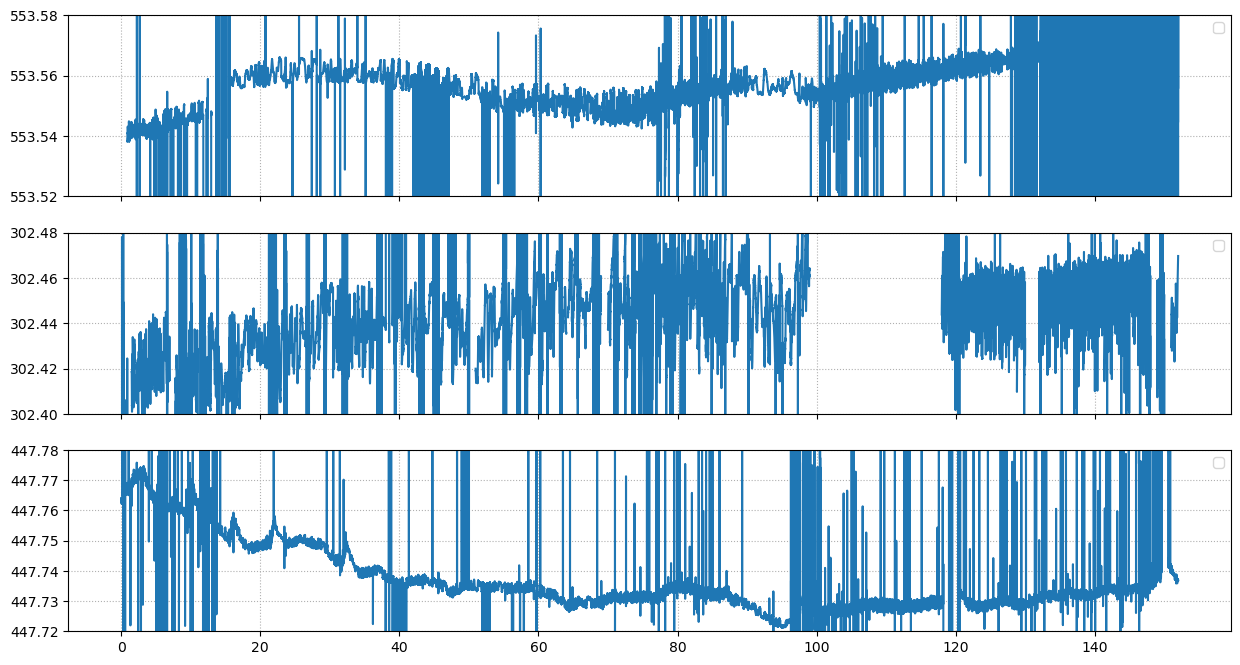

In [223]:
fig = __makeplot(beatZ, beatU, beatV, "fj");

## find jumps

In [224]:
# def __get_phase_jumps(arr, time, fraction_of_pi=36, plot=True):

#     import matplotlib.pyplot as plt
#     import numpy as np
#     from scipy.signal import hilbert

#     data = arr.copy()

#     # define threshold for phase jump identification
#     threshold = np.pi/fraction_of_pi

#     # remove mean of data to avoid jumps at start and end
#     data -= np.nanmean(data)

#     # avoid having to deal with nan values
#     data = np.nan_to_num(data, nan=0)

#     # compute Hilbert transform
#     H = hilbert(data)

#     # obtain angle of hilibert
#     # pha = np.angle(H)
#     pha = np.unwrap(np.angle(H))

#     # derivative of angle
#     dpha = np.gradient(pha, edge_order=1)

#     # dpha /= np.real(H)
#     # dpha /= max(abs(pha))
#     # dpha /= sum((np.gradient(test)))

#     # detect phase changes
#     dpha_y = [_x if abs(_x) > threshold and abs(_x) < 3.14 else np.nan for _x in dpha]

#     # detect phase indices
#     dpha_idx = [list(dpha).index(_x) for _x in dpha if abs(_x) > threshold and abs(_x) < 3.14]

#     # apply filter
#     out = [np.nan if _i in dpha_idx else arr[_i] for _i in range(len(arr))]

#     # checkup plot
#     if plot:
#         fig, ax = plt.subplots(2, 1, figsize=(15, 8))

#         ax[0].plot(time, dpha)
#         ax[0].scatter(time, dpha_y, color="tab:orange", s=10, zorder=2)
#         ax[0].axhline(threshold, color="red", ls="--", alpha=0.5)
#         ax[0].axhline(-threshold, color="red", ls="--", alpha=0.5)

#         ax[1].plot(time, data)
#         for line in time[dpha_idx]:
#             ax[1].axvline(line, -1000, 1000, zorder=0, alpha=0.3, color="tab:orange")

#         plt.show();

#     return np.array(out), time[dpha_idx], np.array(dpha_y)[dpha_idx]

In [225]:
# beatU['fj_fs'], Utt, Uii = __get_phase_jumps(beatU.fj, beatU.times_utc, fraction_of_pi=6, plot=True)
# beatV['fj_fs'], Vtt, Vii = __get_phase_jumps(beatV.fj, beatV.times_utc, fraction_of_pi=6, plot=True)
# beatZ['fj_fs'], Ztt, Zii = __get_phase_jumps(beatZ.fj, beatZ.times_utc, fraction_of_pi=6, plot=True)

In [226]:
from functions.get_phase_jumps_sta_lta import get_phase_jumps_sta_lta

In [227]:
def __reduce_phase_jumps(data, detect):

    data = np.array(data)

    for _i in range(len(data)):

        if detect[_i] == 1:
            left = np.nanmean(data[_i-8:_i-3])
            right = np.nanmean(data[_i+3:_i+8])

            diff = left - right

            data[_i-3:_i] = left

            data[_i:] += diff

    return data

In [228]:
ratio, detect = get_phase_jumps_sta_lta(np.array(beatU.fj), np.array(beatU.times_utc_sec),
                                        5, 3, amp_threshold=0.0001, plot=False)

beatU['fj_dj'] = __reduce_phase_jumps(beatU.fj, detect)

ratio, detect = get_phase_jumps_sta_lta(np.array(beatV.fj), np.array(beatV.times_utc_sec),
                                        5, 3, amp_threshold=0.0001, plot=False)

beatV['fj_dj'] = __reduce_phase_jumps(beatV.fj, detect)

ratio, detect = get_phase_jumps_sta_lta(np.array(beatZ.fj), np.array(beatZ.times_utc_sec),
                                        5, 3, amp_threshold=0.0001, plot=False)

beatZ['fj_dj'] = __reduce_phase_jumps(beatZ.fj, detect)


/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:22: RuntimeWarning: Mean of empty slice
  STA = np.nanmean(abs(_data[n-int(ST):n]))
/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:21: RuntimeWarning: Mean of empty slice
  LTA = np.nanmean(abs(_data[n-int(LT):n]))
/tmp/ipykernel_113467/1803006287.py:8: RuntimeWarning: Mean of empty slice
  left = np.nanmean(data[_i-8:_i-3])
/tmp/ipykernel_113467/1803006287.py:9: RuntimeWarning: Mean of empty slice
  right = np.nanmean(data[_i+3:_i+8])
/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:22: RuntimeWarning: Mean of empty slice
  STA = np.nanmean(abs(_data[n-int(ST):n]))
/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:21: RuntimeWarning: Mean of empty slice
  LTA = np.nanmean(abs(_data[n-int(LT):n]))
/home/andbro/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:21: RuntimeWarning: Mean of empty slice
  LTA = np.nanmean(

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


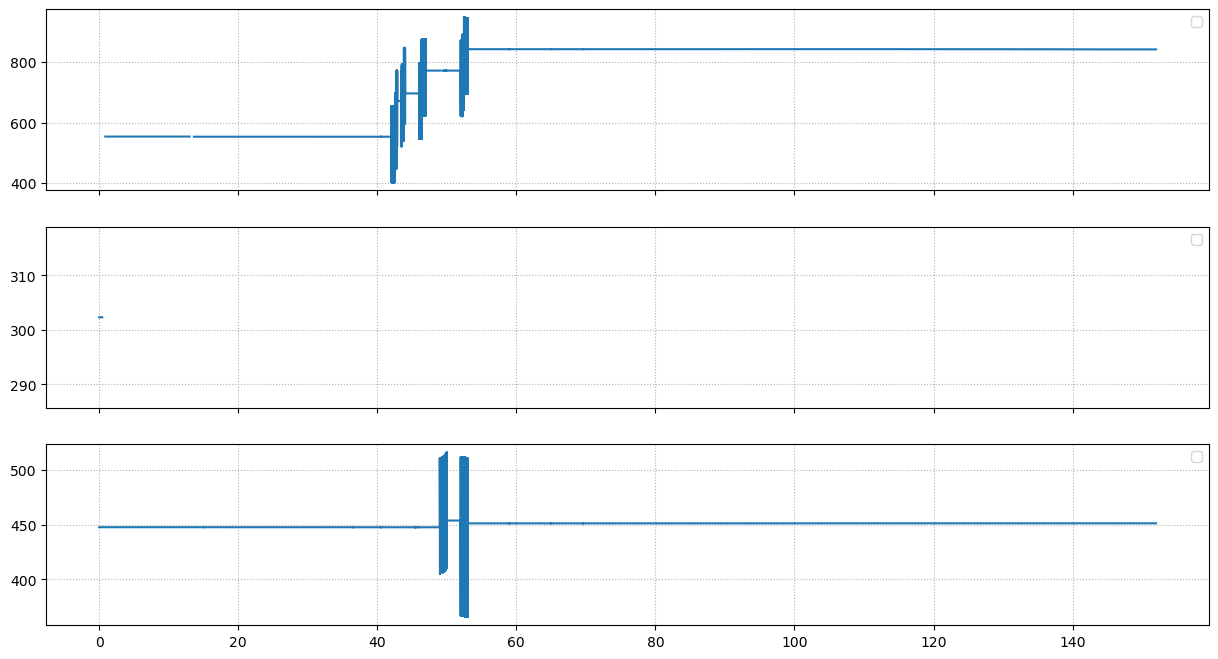

In [229]:
fig = __makeplot(beatZ, beatU, beatV, "fj_dj", limits=False);

## Remove breakdown periods

In [230]:
timesU = [("2023-12-04T09:10", "2023-12-04T18:02"),
          ("2023-12-20T06:10", "2023-12-20T12:01")]

for t1, t2 in timesU:
    beatU['fj'] = np.where((beatU.times_utc > t1) & (beatU.times_utc < t2), np.nan, beatU['fj'])

# beatU['fj'] = np.nan_to_num(beatU['fj'], nan=np.nanmedian(beatU['fj']))

In [231]:
timesV = [("2024-01-01T04:00", "2024-01-01T22:51"),
          ("2024-01-03T14:20", "2024-01-06T00:00"),
          ("2023-12-19T09:40", "2023-12-19T15:21")]

for t1, t2 in timesV:
    beatV['fj'] = np.where((beatV.times_utc > t1) & (beatV.times_utc < t2), np.nan, beatV['fj'])

# beatV['fj'] = np.nan_to_num(beatV['fj'], nan=np.nanmedian(beatV['fj']))

In [280]:
%matplotlib inline

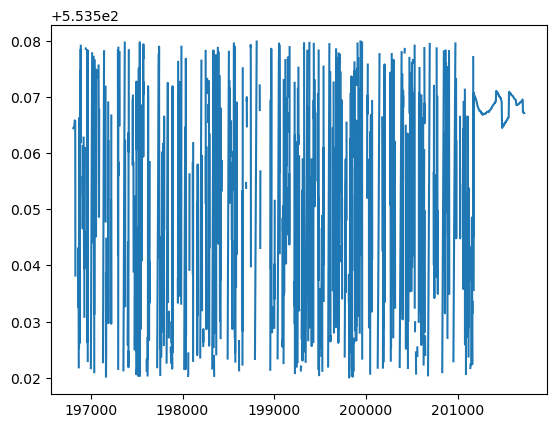

In [281]:
plt.plot(beatZ[(beatZ.times_utc > "2024-05-30 14:00") & (beatZ.times_utc < "2024-06-03 00:00")].fj)

In [232]:
timesZ = [("2023-12-07T00:10", "2023-12-08T18:05"),
          ("2024-05-30T14:00", "2023-12-08T18:05"),]

for t1, t2 in timesZ:
    beatZ['fj'] = np.where((beatZ.times_utc > t1) & (beatZ.times_utc < t2), np.nan, beatZ['fj'])

# beatZ['fj'] = np.nan_to_num(beatZ['fj'], nan=np.nanmedian(beatZ['fj']))

In [233]:
# # beatU['fj'] = np.where((beatU.times_utc < "2023-12-20T07:00:30") & (beatU.fj < 302.4), np.nan, beatU.fj)
# beatU['fj'] = np.where((beatU.fj < 302.4), np.nan, beatU.fj)

# ## cut off outliers manually
# beatU['fj'] = np.where((beatU.times_utc > "2023-12-18T20:40") & (beatU.times_utc < "2023-12-19T05:00") & (beatU.fj < 302.48), np.nan, beatU.fj)


### Exclude Outliers

In [234]:
beatZ['fj'] = np.where((beatZ.fj > Zupper), np.nan, beatZ.fj)
beatZ['fj'] = np.where((beatZ.fj < Zlower), np.nan, beatZ.fj)

beatU['fj'] = np.where((beatU.fj > Uupper), np.nan, beatU.fj)
beatU['fj'] = np.where((beatU.fj < Ulower), np.nan, beatU.fj)

beatV['fj'] = np.where((beatV.fj > Vupper), np.nan, beatV.fj)
beatV['fj'] = np.where((beatV.fj < Vlower), np.nan, beatV.fj)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


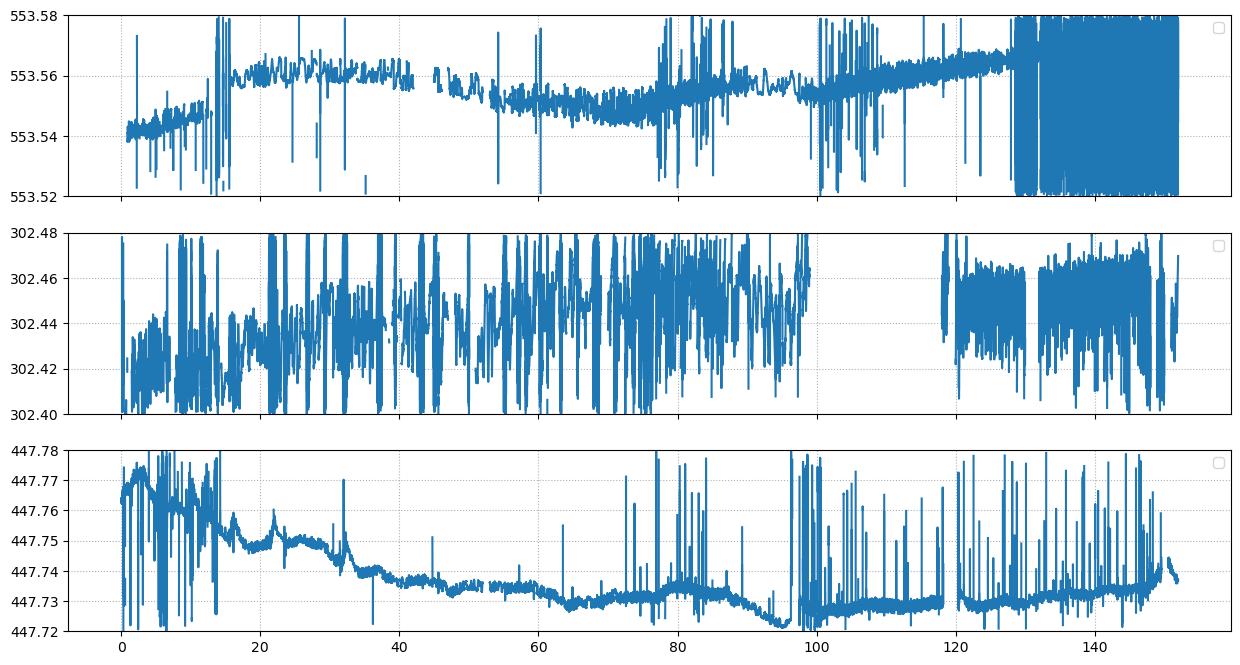

In [235]:
fig = __makeplot(beatZ, beatU, beatV, "fj");

## Load Maintenance LXX log

In [236]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [237]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

## Remove MLTI times

In [238]:
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [239]:
mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

In [240]:
mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

In [241]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [242]:
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

In [243]:
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

In [244]:
from functions.get_mlti_statistics import __get_mlti_statistics

In [245]:
mltiU_cumsum, mltiU_cumsum_percent, mltiU_inter_sec, Utsec = __get_mlti_statistics(mltiU_t1, beatU.times_utc,
                                                                                   plot=False, ylog=False)
mltiV_cumsum, mltiV_cumsum_percent, mltiV_inter_sec, Vtsec = __get_mlti_statistics(mltiV_t1, beatV.times_utc,
                                                                                   plot=False, ylog=False)
mltiZ_cumsum, mltiZ_cumsum_percent, mltiZ_inter_sec, Ztsec = __get_mlti_statistics(mltiZ_t1, beatZ.times_utc,
                                                                                   plot=False, ylog=False)

In [246]:
data = {}

data["Z"] = {"cumsum":mltiZ_cumsum, "cumsump":mltiZ_cumsum_percent, "intersec":mltiZ_inter_sec, "tsec":Ztsec}
data["U"] = {"cumsum":mltiU_cumsum, "cumsump":mltiU_cumsum_percent, "intersec":mltiU_inter_sec, "tsec":Utsec}
data["V"] = {"cumsum":mltiV_cumsum, "cumsump":mltiV_cumsum_percent, "intersec":mltiV_inter_sec, "tsec":Vtsec}

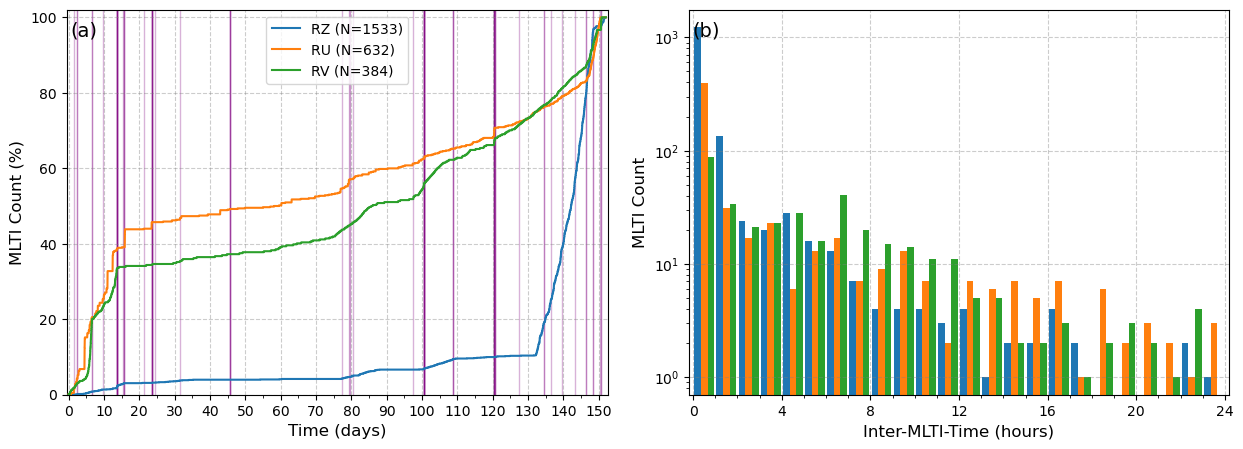

In [253]:
def __makeplot_mlti_statistics(data, ylog=False):

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    tscale = 1/86400

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    plt.subplots_adjust(wspace=0.15)

    offset = [-0.3, 0, 0.3]
    for _i, r in enumerate(data.keys()):
        n = data[r]["cumsum"][-1].astype(int)

        ax[0].plot(data[r]["tsec"]*tscale, data[r]["cumsump"], label=f"R{r} (N={n})", zorder=3)

        h, b = np.histogram(data[r]["intersec"]/3600, bins=int(24/1), range=(0, 24))
        bins = b[:-1] + b[1]/2 + offset[_i]
        ax[1].bar(bins, h, width=0.3)

    if ylog:
        ax[1].set_yscale("log")

    ax[0].set_ylim(0, 102)

    ax[0].set_xlim(0-0.5, max(data[r]["tsec"]*tscale)+0.5)
    ax[1].set_xlim(0-0.2, 24+0.2)

    ax[0].legend(loc=9)

    ax[0].grid(color="grey", ls="--", alpha=0.4)
    ax[1].grid(color="grey", ls="--", alpha=0.4)

    ax[0].set_xlabel("Time (days)", fontsize=12)
    ax[0].set_ylabel("MLTI Count (%)", fontsize=12)

    ax[1].set_xlabel("Inter-MLTI-Time (hours)", fontsize=12)
    ax[1].set_ylabel("MLTI Count", fontsize=12)

    ax[0].xaxis.set_major_locator(MultipleLocator(10))
    ax[0].xaxis.set_minor_locator(MultipleLocator(5))
    ax[1].xaxis.set_major_locator(MultipleLocator(4))
    ax[1].xaxis.set_minor_locator(MultipleLocator(1))

    for _k, ll in enumerate(['(a)', '(b)']):
        ax[_k].text(.006, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=14)

    # add maintenance times
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = (lx1-UTCDateTime(config['tbeg']))*tscale
        lx2_sec = (lx2-UTCDateTime(config['tbeg']))*tscale
        ax[0].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="purple", alpha=0.3)


    plt.show();
    return fig

fig = __makeplot_mlti_statistics(data, ylog=True)

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_mlti_statistics.png", format="png", dpi=150, bbox_inches='tight')


### Set MLTI intervals to NaN

In [254]:
beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)
beatV = __mlti_intervals_to_NaN(beatV, "fj", "times_utc", mltiV_t1, mltiV_t2, t_offset_sec=180)
beatZ = __mlti_intervals_to_NaN(beatZ, "fj", "times_utc", mltiZ_t1, mltiZ_t2, t_offset_sec=180)

## Interpolate NaN values

In [255]:
beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))
beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))
beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

## Smoothing

In [256]:
n_minutes = 12*60

beatU['fj_smooth'] = __smooth(beatU.fj_inter, n_minutes)
beatV['fj_smooth'] = __smooth(beatV.fj_inter, n_minutes)
beatZ['fj_smooth'] = __smooth(beatZ.fj_inter, n_minutes)

beatU['fj_dj_smooth'] = __smooth(beatU.fj_dj, n_minutes)
beatV['fj_dj_smooth'] = __smooth(beatV.fj_dj, n_minutes)
beatZ['fj_dj_smooth'] = __smooth(beatZ.fj_dj, n_minutes)

from scipy.ndimage import gaussian_filter1d

# n = 180

# beatU['fj_smooth'] = gaussian_filter1d(beatU.fj_inter, n)
# beatV['fj_smooth'] = gaussian_filter1d(beatV.fj_inter, n)
# beatZ['fj_smooth'] = gaussian_filter1d(beatZ.fj_inter, n)

# beatU['fj_dj_smooth'] = gaussian_filter1d(beatU.fj_dj, n)
# beatV['fj_dj_smooth'] = gaussian_filter1d(beatV.fj_dj, n)
# beatZ['fj_dj_smooth'] = gaussian_filter1d(beatZ.fj_dj, n)

## Masks

In [257]:
maskU = np.where(np.isnan(beatU.fj_nan), np.nan, 1)
maskV = np.where(np.isnan(beatV.fj_nan), np.nan, 1)
maskZ = np.where(np.isnan(beatZ.fj_nan), np.nan, 1)

In [258]:
beatU['fj_smooth_masked'] = beatU['fj_smooth'] * maskU
beatV['fj_smooth_masked'] = beatV['fj_smooth'] * maskV
beatZ['fj_smooth_masked'] = beatZ['fj_smooth'] * maskZ

## Plotting

In [259]:
# Zlower, Zupper = 553.50, 553.60
# Ulower, Uupper = 302.39, 302.49
# Vlower, Vupper = 447.70, 447.80

/tmp/ipykernel_113467/1112775776.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


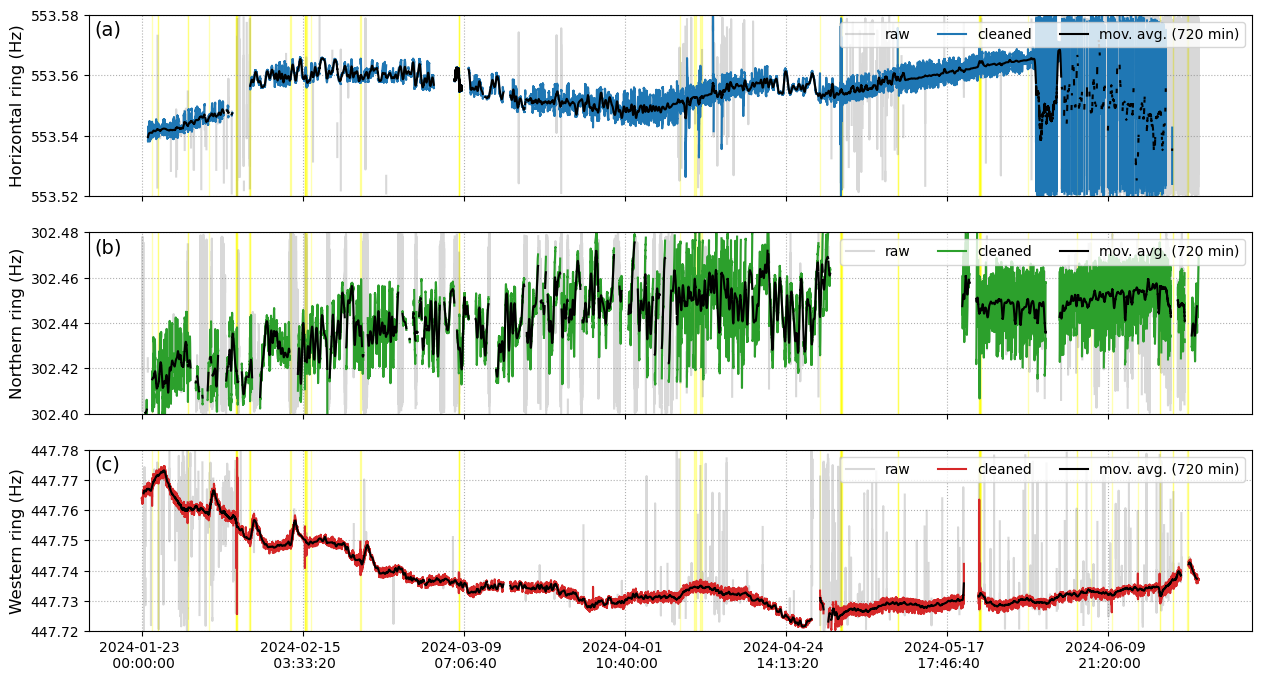

In [260]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="cleaned")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(Zlower, Zupper)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal ring (Hz)", fontsize=font)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label="cleaned")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[1].set_ylim(Ulower, Uupper)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern ring (Hz)", fontsize=font)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="cleaned")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[2].set_ylim(Vlower, Vupper)
    ax[2].set_ylim()

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western ring (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_smoothed.png", format="png", dpi=150, bbox_inches='tight')


In [261]:
Zlower2, Zupper2 = 553.558, 553.574
Ulower2, Uupper2 = 302.435, 303.100
Vlower2, Vupper2 = 447.730, 447.744

/tmp/ipykernel_113467/2348800278.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


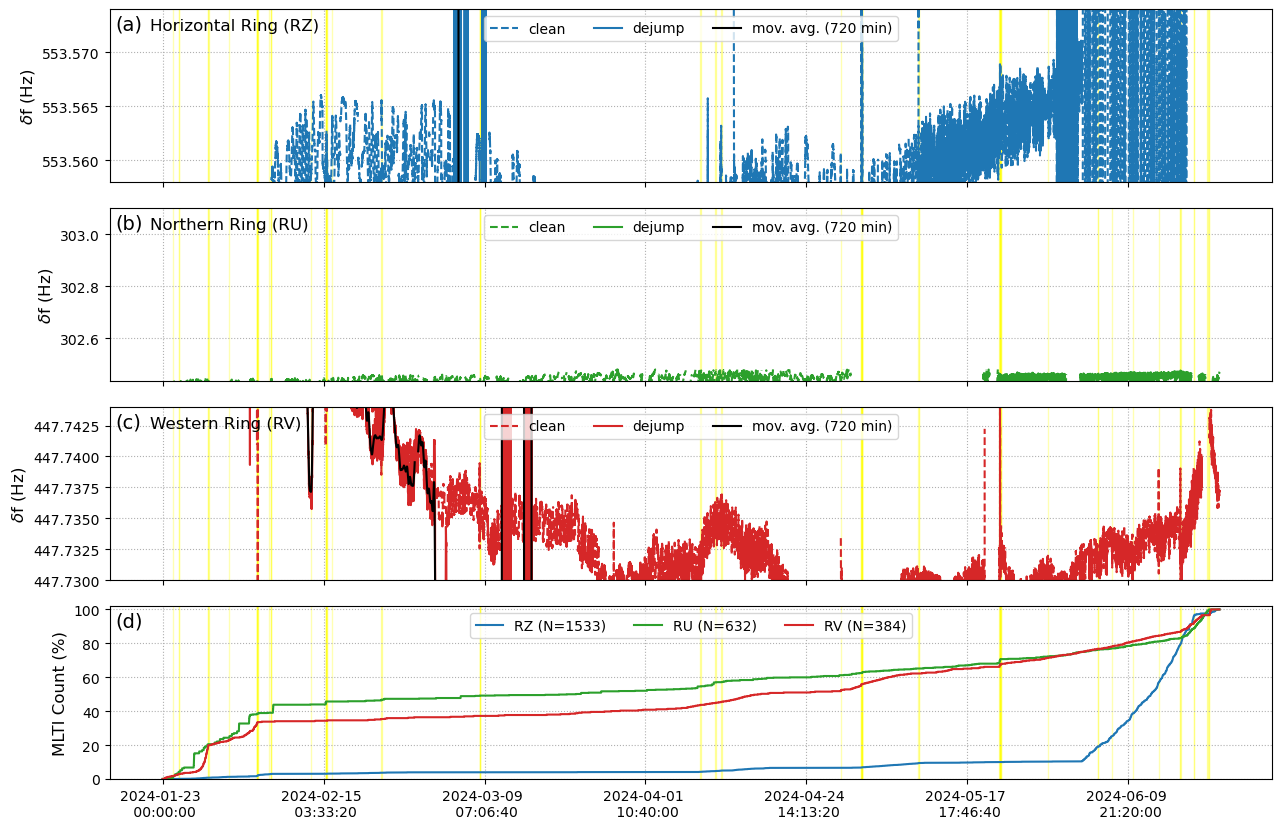

In [262]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])
    ref_date = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.15)

    # time_scaling = 1/86400
    time_scaling = 1

    # ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="clean", ls="--")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_dj, color="tab:blue", label="dejump")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_dj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[0].text(.035, .95, "Horizontal Ring (RZ)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font)

    # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label="clean", ls="--")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_dj, color="tab:green", label="dejump")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_dj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[1].text(.035, .95, "Northern Ring (RU)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font)

    # ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="clean", ls="--")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_dj, color="tab:red", label="dejump")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_dj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[2].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[2].text(.035, .95, "Western Ring (RV)", ha='left', va='top', transform=ax[2].transAxes, fontsize=font)

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("$\delta$f (Hz)", fontsize=font)

    n_rz, n_ru, n_rv = int(mltiZ_cumsum[-1]), int(mltiU_cumsum[-1]), int(mltiV_cumsum[-1])
    ax[3].plot(beatZ.times_utc_sec*time_scaling, mltiZ_cumsum_percent, color="tab:blue", label=f"RZ (N={n_rz})")
    ax[3].plot(beatU.times_utc_sec*time_scaling, mltiU_cumsum_percent, color="tab:green", label=f"RU (N={n_ru})")
    ax[3].plot(beatV.times_utc_sec*time_scaling, mltiV_cumsum_percent, color="tab:red", label=f"RV (N={n_rv})")
    # ax[3].set_yscale("log")
    # ax[3].set_ylim(0, max([n_rz, n_rv, n_ru])+2)
    ax[3].set_ylim(0, 102)
    ax[3].set_ylabel("MLTI Count (%)", fontsize=font)

    ax[0].set_ylim(Zlower2, Zupper2)
    ax[1].set_ylim(Ulower2, Uupper2)
    ax[2].set_ylim(Vlower2, Vupper2)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=9, ncol=4)

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_dejump_smoothed.png", format="png", dpi=150, bbox_inches='tight')


## Rotate to ZNE

In [201]:
from functions.reduce import __reduce

# beatU['fj_reduced'] = __reduce(beatU['fj_smooth'], 60)
# beatV['fj_reduced'] = __reduce(beatV['fj_smooth'], 60)
# beatZ['fj_reduced'] = __reduce(beatZ['fj_smooth'], 60)

beatU['fj_reduced'] = __reduce(beatU['fj_dj_smooth'], 10)
beatV['fj_reduced'] = __reduce(beatV['fj_dj_smooth'], 10)
beatZ['fj_reduced'] = __reduce(beatZ['fj_dj_smooth'], 10)

In [202]:
beatU['fj_reduced_masked'] = beatU['fj_reduced'] * maskU
beatV['fj_reduced_masked'] = beatV['fj_reduced'] * maskV
beatZ['fj_reduced_masked'] = beatZ['fj_reduced'] * maskZ

In [203]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.fj_reduced_masked)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.stats.network, tr_beatU.stats.station, tr_beatU.stats.channel = "BW", "ROMY", "LJU"
# tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.fj_reduced_masked)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.stats.network, tr_beatV.stats.station, tr_beatV.stats.channel = "BW", "ROMY", "LJV"
# tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.fj_reduced_masked)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.stats.network, tr_beatZ.stats.station, tr_beatZ.stats.channel = "BW", "ROMY", "LJZ"
# tr_beatZ.plot();

st_beat = Stream(traces=[tr_beatU, tr_beatV, tr_beatZ])

etime = min(st_beat[0].stats.endtime, st_beat[1].stats.endtime, st_beat[2].stats.endtime)
st_beat = st_beat.trim(st_beat[0].stats.starttime, etime)

st_beat

3 Trace(s) in Stream:
BW.ROMY..LJU | 2024-07-05T00:00:30.000000Z - 2024-07-15T23:59:30.000000Z | 60.0 s, 15840 samples
BW.ROMY..LJV | 2024-07-05T00:00:30.000000Z - 2024-07-15T23:59:30.000000Z | 60.0 s, 15840 samples
BW.ROMY..LJZ | 2024-07-05T00:00:30.000000Z - 2024-07-15T23:59:30.000000Z | 60.0 s, 15840 samples

In [204]:
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE

In [205]:
config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

romy_inv = read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

st_beat_zne = __rotate_romy_ZUV_ZNE(st_beat, romy_inv)

# st_beat_zne.plot();

/tmp/ipykernel_113467/2875088119.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


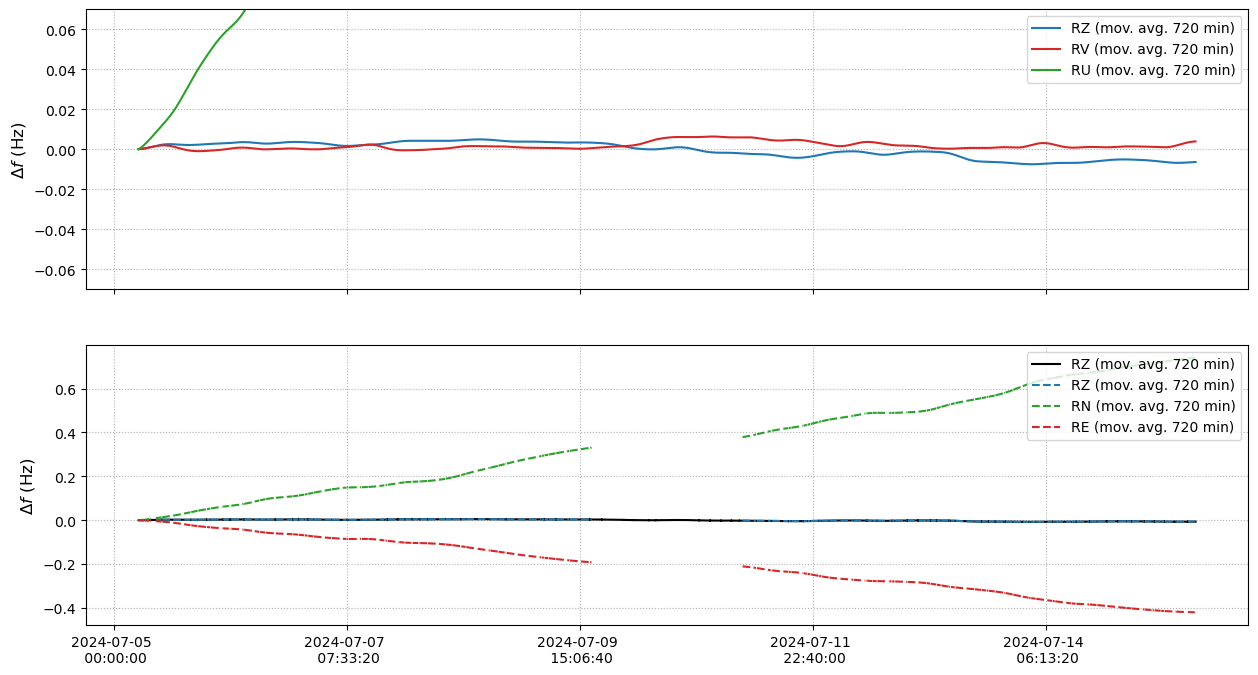

In [206]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)


    # ax[1].plot(beatZ.times_utc_sec*time_scaling, beatZ.tilt_reduced*tilt_scaling, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatV.times_utc_sec*time_scaling, beatV.tilt_reduced*tilt_scaling, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.tilt_reduced*tilt_scaling, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat.select(channel="*Z")[0].data,
               color="black", label=f"RZ (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat_zne.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*Z")[0].data,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*N")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*N")[0].data,
               color="tab:green", label=f"RN (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*E")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*E")[0].data,
               color="tab:red", label=f"RE (mov. avg. {n_minutes} min)", ls="--")


    # ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_smoothed_ZNE.png", format="png", dpi=150, bbox_inches='tight')


## Tilt

In [207]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

In [208]:
# N-S
beatZ['tilt'] = __sagnac_to_tilt(beatZ['fj_reduced'], "Z", tilt='n-s')
beatU['tilt'] = __sagnac_to_tilt(beatU['fj_reduced'], "U", tilt='n-s')
beatV['tilt'] = __sagnac_to_tilt(beatV['fj_reduced'], "V", tilt='n-s')

# E-W
# beatZ['tilt'] = __sagnac_to_tilt(beatZ['fj_reduced'], "Z", tilt='e-w')
# beatU['tilt'] = __sagnac_to_tilt(beatU['fj_reduced'], "U", tilt='e-w')
# beatV['tilt'] = __sagnac_to_tilt(beatV['fj_reduced'], "V", tilt='e-w')

beatU['tilt_reduced'] = beatU.tilt - np.nanmean(beatU.tilt.iloc[:1440])
beatV['tilt_reduced'] = beatV.tilt - np.nanmean(beatV.tilt.iloc[:1440])
beatZ['tilt_reduced'] = beatZ.tilt - np.nanmean(beatZ.tilt.iloc[:1440])

In [209]:
beatU['tilt_reduced_masked'] = beatU['tilt_reduced'] * maskU
beatV['tilt_reduced_masked'] = beatV['tilt_reduced'] * maskV
beatZ['tilt_reduced_masked'] = beatZ['tilt_reduced'] * maskZ

In [210]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.tilt_reduced_masked)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.stats.network, tr_beatU.stats.station, tr_beatU.stats.channel = "BW", "ROMY", "LAU"
# tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.tilt_reduced_masked)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.stats.network, tr_beatV.stats.station, tr_beatV.stats.channel = "BW", "ROMY", "LAV"
# tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.tilt_reduced_masked)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.stats.network, tr_beatZ.stats.station, tr_beatZ.stats.channel = "BW", "ROMY", "LAZ"
# tr_beatZ.plot();

st_tilt = Stream(traces=[tr_beatU, tr_beatV, tr_beatZ])

etime = min(st_tilt[0].stats.endtime, st_tilt[1].stats.endtime, st_tilt[2].stats.endtime)
st_tilt = st_tilt.trim(st_tilt[0].stats.starttime, etime)

# rotate to ZNE system
# st_tilt = __rotate_romy_ZUV_ZNE(st_tilt, romy_inv)

st_tilt

3 Trace(s) in Stream:
BW.ROMY..LAU | 2024-07-05T00:00:30.000000Z - 2024-07-15T23:59:30.000000Z | 60.0 s, 15840 samples
BW.ROMY..LAV | 2024-07-05T00:00:30.000000Z - 2024-07-15T23:59:30.000000Z | 60.0 s, 15840 samples
BW.ROMY..LAZ | 2024-07-05T00:00:30.000000Z - 2024-07-15T23:59:30.000000Z | 60.0 s, 15840 samples

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_113467/4231354760.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


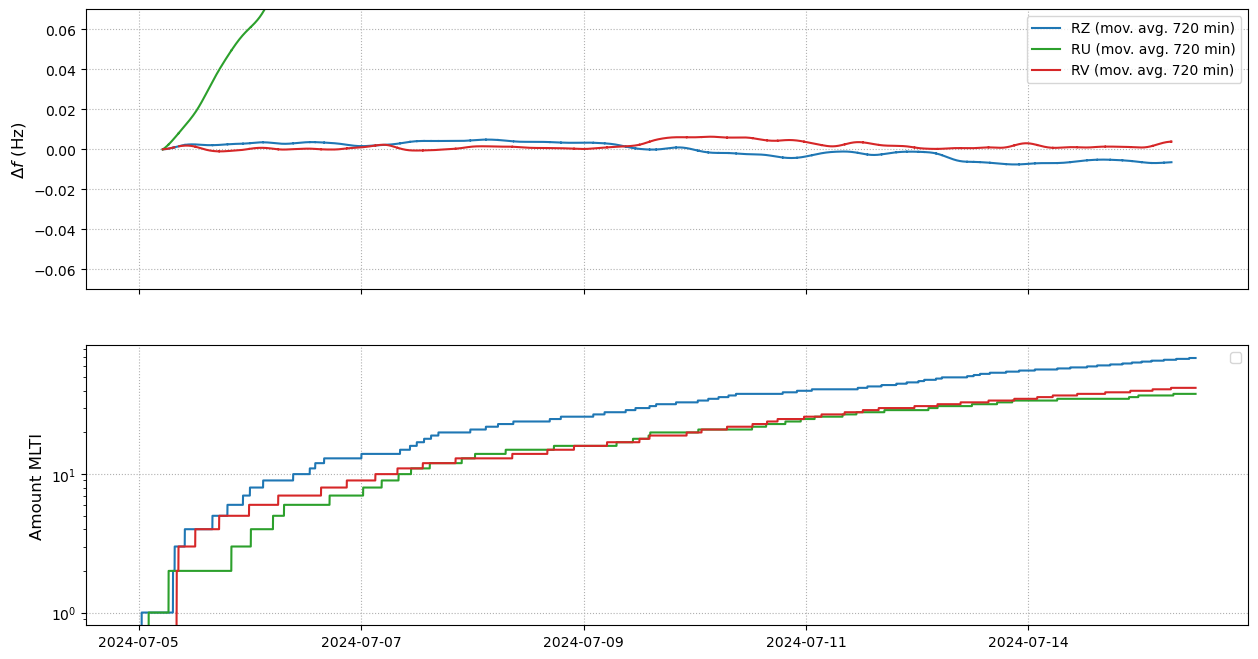

In [211]:
def __makeplot_mlti():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced_masked, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced_masked, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced_masked, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)


    ax[1].plot(beatZ.times_utc_sec*time_scaling, mltiZ_cumsum, color="tab:blue")
    ax[1].plot(beatU.times_utc_sec*time_scaling, mltiU_cumsum, color="tab:green")
    ax[1].plot(beatV.times_utc_sec*time_scaling, mltiV_cumsum, color="tab:red")

    ax[1].set_ylabel("Amount MLTI", fontsize=font)

    ax[1].set_yscale("log")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_mlti();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_mlti.png", format="png", dpi=150, bbox_inches='tight')


### load water level data

In [212]:
from functions.load_water_level import __load_water_level

try:
    # load data
    pegel =  __load_water_level(config['tbeg'], config['tend'], path_to_data=root_path+"lamont/Pegel/")

    # remove error measurements with nan
    pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

except:
    print(" -> pegel not loaded")


### load barometer data

In [213]:
from andbro__read_sds import __read_sds

ffbi = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])


In [214]:
ffbi.merge(fill_value="interpolate")

1 Trace(s) in Stream:
BW.FFBI.30.LDO | 2024-07-05T00:00:00.005000Z - 2024-07-15T23:59:59.005000Z | 1.0 Hz, 950400 samples

### Plotting

In [215]:
def __makeplot_tilt_pegel():

    Nrow, Ncol = 3, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced_masked, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced_masked, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced_masked, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta$ f (Hz)", fontsize=font)


    ax[1].plot(st_tilt.select(channel="*Z")[0].times(reftime=ref_date),
               st_tilt.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_tilt.select(channel="*U")[0].times(reftime=ref_date),
               st_tilt.select(channel="*U")[0].data*tilt_scaling,
               color="tab:green", label=f"RU (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_tilt.select(channel="*V")[0].times(reftime=ref_date),
               st_tilt.select(channel="*V")[0].data*tilt_scaling,
               color="tab:red", label=f"RV (mov. avg. {n_minutes} min)", ls="--")


    ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel, color="purple", alpha=0.9, zorder=3)
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font)

    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    # ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    for _k, ll in enumerate(['(a)', '(b)', '(c)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

# fig = __makeplot_tilt_pegel();

# fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_tilt_pegel.png", format="png", dpi=150, bbox_inches='tight')


In [216]:
def __makeplot_tilt_pegel_baro():

    Nrow, Ncol = 4, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced_masked, color="tab:blue", label=f"RZ")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced_masked, color="tab:red", label=f"RV")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced_masked, color="tab:green", label=f"RU")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta$ f (Hz)", fontsize=font)


    ax[1].plot(st_tilt.select(channel="*Z")[0].times(reftime=ref_date),
               st_tilt.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ", ls="-")
    ax[1].plot(st_tilt.select(channel="*U")[0].times(reftime=ref_date),
               st_tilt.select(channel="*U")[0].data*tilt_scaling,
               color="tab:green", label=f"RU", ls="-")
    ax[1].plot(st_tilt.select(channel="*V")[0].times(reftime=ref_date),
               st_tilt.select(channel="*V")[0].data*tilt_scaling,
               color="tab:red", label=f"RV", ls="-")


    ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel,
               label="water level",
               color="purple", alpha=0.9, zorder=3)


    ax[3].plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date)),
               ffbi.select(channel="*O")[0].data*100,
               label=f"{ffbi.select(channel='*O')[0].stats.station}.{ffbi.select(channel='*O')[0].stats.channel}",
               color="tab:red")

    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font)
    ax[3].set_ylabel(f"Air Pressure (hPa)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    ax[0].set_title(f"mov. avg. {n_minutes} min")

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

# fig = __makeplot_tilt_pegel_baro();

# fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_tilt_pegel_baro.png", format="png", dpi=150, bbox_inches='tight')


/tmp/ipykernel_113467/2506106264.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


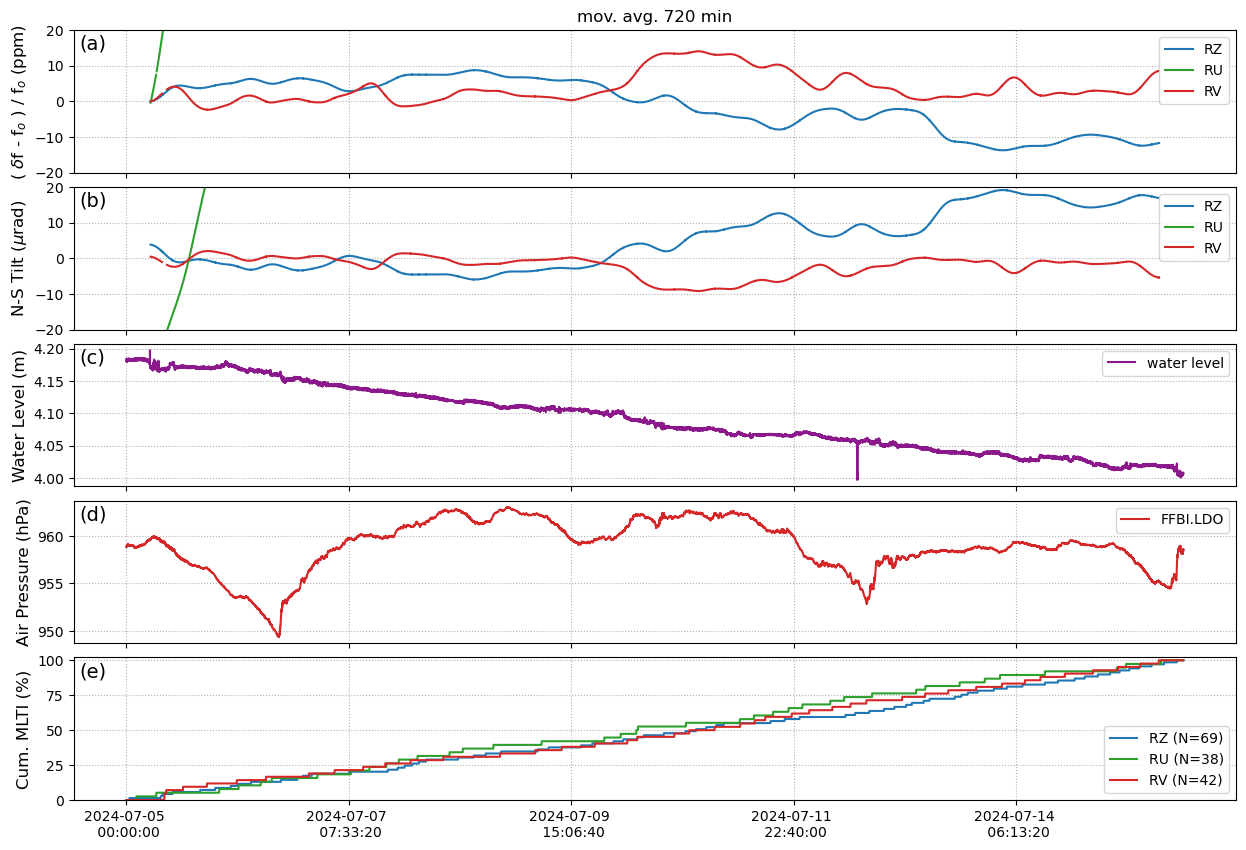

In [218]:
def __makeplot_tilt_pegel_baro():

    Nrow, Ncol = 5, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced_masked/beatZ.fj.iloc[0]*1e6, color="tab:blue", label=f"RZ")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced_masked/beatU.fj.iloc[0]*1e6, color="tab:green", label=f"RU")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced_masked/beatV.fj.iloc[0]*1e6, color="tab:red", label=f"RV")

    ax[0].ticklabel_format(useOffset=False)
    # ax[0].set_ylabel("$\Delta$f (Hz)", fontsize=font)
    ax[0].set_ylabel("( $\delta$f - f$_o$ ) / f$_o$ (ppm)", fontsize=font)


    ax[1].plot(st_tilt.select(channel="*Z")[0].times(reftime=ref_date),
               st_tilt.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ", ls="-")
    ax[1].plot(st_tilt.select(channel="*U")[0].times(reftime=ref_date),
               st_tilt.select(channel="*U")[0].data*tilt_scaling,
               color="tab:green", label=f"RU", ls="-")
    ax[1].plot(st_tilt.select(channel="*V")[0].times(reftime=ref_date),
               st_tilt.select(channel="*V")[0].data*tilt_scaling,
               color="tab:red", label=f"RV", ls="-")


    ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel,
               label="water level",
               color="purple", alpha=0.9, zorder=3)


    ax[3].plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date)),
               ffbi.select(channel="*O")[0].data,
               label=f"{ffbi.select(channel='*O')[0].stats.station}.{ffbi.select(channel='*O')[0].stats.channel}",
               color="tab:red")


    ax[4].plot(beatZ.times_utc_sec*time_scaling, mltiZ_cumsum_percent, color="tab:blue", label=f"RZ (N={int(mltiZ_cumsum[-1])})")
    ax[4].plot(beatU.times_utc_sec*time_scaling, mltiU_cumsum_percent, color="tab:green", label=f"RU (N={int(mltiU_cumsum[-1])})")
    ax[4].plot(beatV.times_utc_sec*time_scaling, mltiV_cumsum_percent, color="tab:red", label=f"RV (N={int(mltiV_cumsum[-1])})")

    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font)
    ax[3].set_ylabel(f"Air Pressure (hPa)", fontsize=font)
    ax[4].set_ylabel("Cum. MLTI (%)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[4].legend(loc=4)

    # ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-20, 20)
    ax[1].set_ylim(-20, 20)
    ax[4].set_ylim(0, 102)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    ax[0].set_title(f"mov. avg. {n_minutes} min")

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tilt_pegel_baro();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_tilt_pegel_baro_mlti.png", format="png", dpi=150, bbox_inches='tight')


In [57]:
def __sagnac_to_rads(data, ring):

    from numpy import pi, sqrt, arccos, deg2rad, sin, cos

    dip = {"Z":0, "U":109.5, "V":70.5, "W":70.5}

    L = {"Z":11.2, "U":12, "V":12, "W":12}

    ## Scale factor
    S = (sqrt(3)*L[ring])/(3*632.8e-9)

    ## ROMY latitude
    lat = 48.162941

    ## nominal Earth rotation
    omegaE = 2*pi/86400

    return data /S /sin(deg2rad(lat+dip[ring]))

In [58]:

st_rad = st_beat.copy()

for tr in st_rad:
    tr.data = __sagnac_to_rads(tr.data, tr.stats.channel[-1])
    tr.data = __interpolate_nan(tr.data)


st_rad = st_rad.integrate(method='cumtrapz')
# st_rad = st_rad.integrate(method='spline')

# import scipy.integrate as integrate
# for tr in st_rad:
#     tr.data = integrate.quad(tr.data, 0, len(tr.data))

st_rad = __rotate_romy_ZUV_ZNE(st_rad, romy_inv)


# st_rad.plot(equal_scale=False)

/tmp/ipykernel_205588/2909398767.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


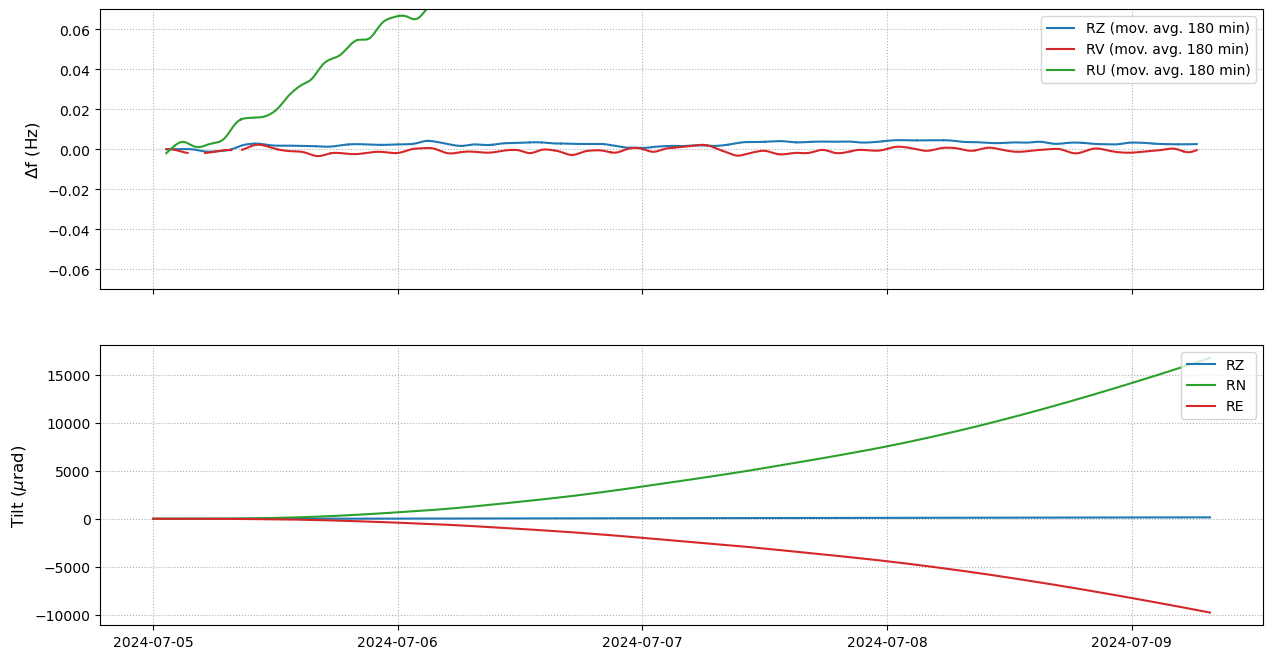

In [59]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(st_beat.select(channel="*Z")[0].times()*time_scaling,
               st_beat.select(channel="*Z")[0].data,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(st_beat.select(channel="*V")[0].times()*time_scaling,
               st_beat.select(channel="*V")[0].data,
               color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(st_beat.select(channel="*U")[0].times()*time_scaling,
               st_beat.select(channel="*U")[0].data,
               color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta$f (Hz)", fontsize=font)


    ax[1].plot(st_rad.select(channel="*Z")[0].times()*time_scaling,
               st_rad.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ")
    ax[1].plot(st_rad.select(channel="*N")[0].times()*time_scaling,
               st_rad.select(channel="*N")[0].data*tilt_scaling,
               color="tab:green", label=f"RN ")
    ax[1].plot(st_rad.select(channel="*E")[0].times()*time_scaling,
               st_rad.select(channel="*E")[0].data*tilt_scaling,
               color="tab:red", label=f"RE")


    ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)
    ax[1].set_ylabel("Tilt ($\mu$rad)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_smoothed_asTilt.png", format="png", dpi=150, bbox_inches='tight')


In [60]:
st_rad

3 Trace(s) in Stream:
BW.ROMY..LJN | 2024-07-05T00:00:30.000000Z - 2024-07-09T23:59:30.000000Z | 60.0 s, 7200 samples
BW.ROMY..LJE | 2024-07-05T00:00:30.000000Z - 2024-07-09T23:59:30.000000Z | 60.0 s, 7200 samples
BW.ROMY..LJZ | 2024-07-05T00:00:30.000000Z - 2024-07-09T23:59:30.000000Z | 60.0 s, 7200 samples

In [61]:
def __get_vector_movement(N, E, Twin=3600, ref_date=None, plot=False):

    from numpy import median, sqrt, arctan, degrees, mod, array, append, rad2deg, nan, ma, deg2rad

    dt = N[0].stats.delta
    t1 = 0

    Ndata = N[0].data
    Edata = E[0].data

    if ma.is_masked(Ndata):
        Ndata = ma.filled(Ndata, fill_value=nan)
    if ma.is_masked(Edata):
        Edata = ma.filled(Edata, fill_value=nan)

    vnorm, vdir, timeline = [], [], []
    while (t1 + Twin) < N[0].stats.npts*dt:

        Nmed = median(Ndata[int(t1/dt):int((t1+Twin)/dt)])
        Emed = median(Edata[int(t1/dt):int((t1+Twin)/dt)])


        vnorm.append(sqrt(Nmed**2 + Emed**2))

        if Nmed > 0 and Emed > 0:
            vdir.append(90-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed > 0:
            vdir.append(90+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed < 0:
            vdir.append(270-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed > 0 and Emed < 0:
            vdir.append(270+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        else:
            vdir.append(nan)

        t1 += Twin/2

        timeline.append(t1)

    if ref_date:
        time_offset = abs(UTCDateTime(ref_date) - N[0].stats.starttime)
    else:
        time_offset = 0

    vnorm = array(vnorm)
    vdir = array(vdir)
    timeline = (array(timeline) + time_offset)/3600 ## in hours


    ## Plotting ------------------------------------
    if plot:

        from numpy import deg2rad, arange, linspace
        import matplotlib.pyplot as plt

        vnorm = vnorm
        vdirection = vdir

        ## times to days
        times = timeline /24

        time_min = min(times)
        time_max = max(times)

        ## Plot --------------------------------------------------------------------------
        fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(5, 5))

        font = 12

        cmap = plt.get_cmap('viridis')

        vscaling, vunit = 1e3, "mrad"

        ## convert degrees to radians for plotting as polar!
        p0 = ax.scatter(deg2rad(vdirection), vnorm*vscaling, c=times, cmap=cmap,
                        vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)

        cbar = plt.colorbar(p0, ax=ax,  pad=0.1, orientation='vertical', fraction=0.1, shrink=.8)

        if ref_date:
            cbar.set_label('Time (days)', rotation=90, fontsize=font, labelpad=10)
        else:
            cbar.set_label(f'Time from {ref_date} (days)', rotation=90, fontsize=font, labelpad=10)

        ## set new colorbar ticks
        # ref_time = config['tbeg']
        # nticks = [str((ref_time+time_min+t*86400).date) for t in cbar.get_ticks()]
        # cbar.set_ticklabels(nticks)

        vmax = round(max(vnorm*vscaling) * 1.1, 0)

        ax.set_ylim(0, vmax)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)

        ax.text(deg2rad(25), vmax*1.2, f"({vunit})")
        ax.set_rgrids(linspace(0., vmax, 5), angle=25., zorder=0)

        ax.set_title("Tilt of ROMY structure", fontsize=font)

        plt.show();

    return timeline, vdir, vnorm

In [62]:
def __makeplot_normal_vector_movement(times, vdirection, vnorm, ref_date=None):

    from numpy import deg2rad, arange, linspace
    import matplotlib.pyplot as plt

    ## times to days
    times = times /24

    time_min = min(times)
    time_max = max(times)

    ## Plot --------------------------------------------------------------------------
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(5, 5))

    font = 12

    cmap = plt.get_cmap('viridis')

    vscaling, vunit = 1e3, "mrad"

    ## convert degrees to radians for plotting as polar!
    p0 = ax.scatter(deg2rad(vdirection), vnorm*vscaling, c=times, cmap=cmap,
                    vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)

    cbar = plt.colorbar(p0, ax=ax,  pad=0.1, orientation='vertical', fraction=0.1, shrink=.8)

    if ref_date is not None:
        cbar.set_label('Time (days)', rotation=90, fontsize=font, labelpad=10)
    else:
        cbar.set_label(f'Time from {ref_date} (days)', rotation=90, fontsize=font, labelpad=10)

    ## set new colorbar ticks
    # ref_time = config['tbeg']
    # nticks = [str((ref_time+time_min+t*86400).date) for t in cbar.get_ticks()]
    # cbar.set_ticklabels(nticks)

    vmax = round(max(vnorm*vscaling) * 1.1, 0)

    ax.set_ylim(0, vmax)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.text(deg2rad(25), vmax*1.2, f"({vunit})")
    ax.set_rgrids(linspace(0., vmax, 5), angle=25., zorder=0)

    ax.set_title("Tilt of ROMY structure", fontsize=font)

    plt.show();
    return fig

In [63]:
twindow = 3600  ## seconds

ttimes, vector_direction, vector_norm = __get_vector_movement(st_rad.select(channel="*N"),
                                                              st_rad.select(channel="*E"),
                                                              Twin=twindow,
                                                              plot=False,
                                                              )


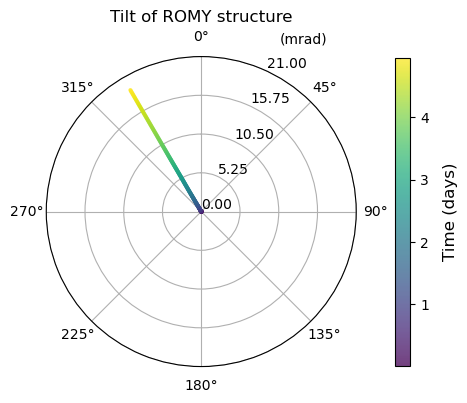

In [64]:

fig = __makeplot_normal_vector_movement(ttimes, vector_direction, vector_norm, ref_date=st_rad[0].stats.starttime.date)

# fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_vector_movement.png", format="png", dpi=150, bbox_inches='tight')


## Tides

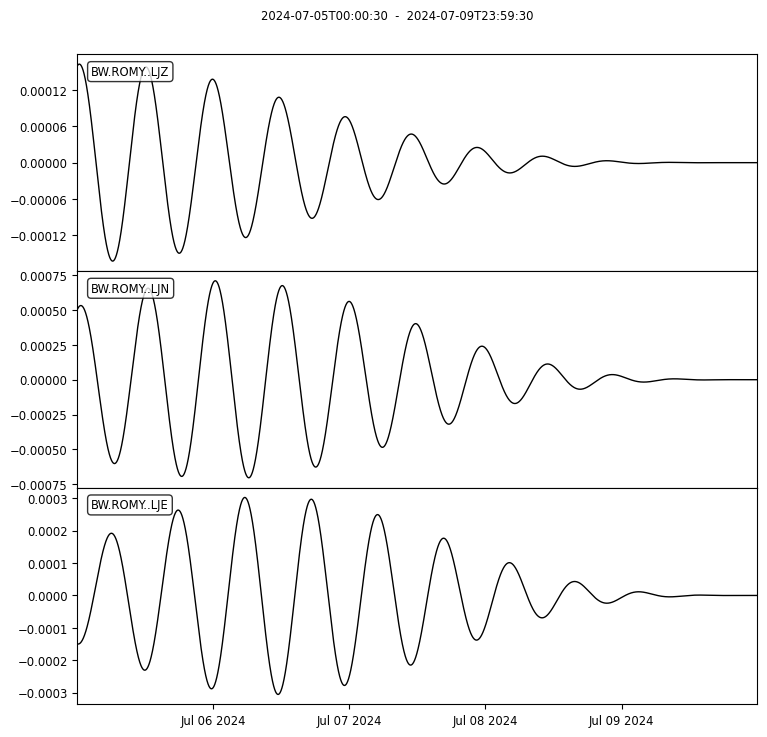

In [65]:
st_beat_zne_tide = st_beat_zne.copy();

for tr in st_beat_zne_tide:
    tr.data = __interpolate_nan(tr.data)

## daily
# f1 = 1/(25*3600)
# f2 = 1/(23*3600)

## sub-daily
f1 = 1/(13*3600)
f2 = 1/(11*3600)

st_beat_zne_tide.detrend("linear")
st_beat_zne_tide.taper(0.1)
st_beat_zne_tide.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)

st_beat_zne_tide.plot(equal_scale=False);


### Load Tilt Data

In [66]:
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from functions.conversion_to_tilt import __conversion_to_tilt

 -> failed to obtain waveforms!
 -> failed to obtain waveforms!
  -> converted data of DROMY


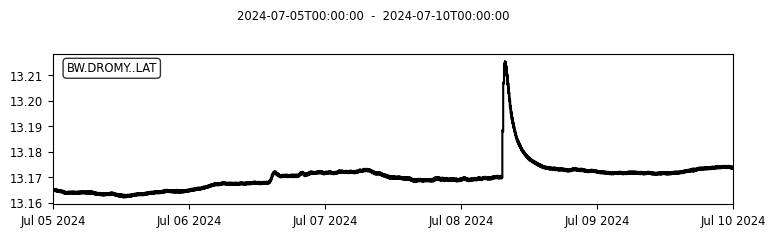

In [67]:
path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

# sta, cha, name = "TROMY", "MA", "TROMY"
sta, cha, name = "DROMY", "LA", "BROMY"

tilt =  __read_sds(path_to_tilt, f"BW.{sta}..{cha}T", config['tbeg']-600, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..{cha}N", config['tbeg']-600, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..{cha}E", config['tbeg']-600, config['tend']+600)

## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tilt = __conversion_to_tilt(tilt, confTilt[f'{name}'])

tilt = tilt.trim(config['tbeg'], config['tend'])

tilt.plot(equal_scale=False);

gc.collect();

In [68]:
tides = Stream()

tides += st_rad.copy()
tides += tilt.copy()

tides = tides.resample(0.005, no_filter=False);

# f1, f2 = 1/(15*3600), 1/(11*3600)
# f1, f2 = 1/(25*3600), 1/(23*3600)

# tides = tides.detrend("simple")
# tides = tides.taper(0.01)
# tides = tides.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)

# tides.merge();

tides.plot(equal_scale=False);

ArithmeticError: Automatic filter design is unstable for resampling factors (current sampling rate/new sampling rate) above 16. Manual resampling is necessary.

In [ ]:
def __makeplot_tides():


    f1_subdaily, f2_subdaily = 1/(13*3600), 1/(11*3600)

    f1_daily, f2_daily = 1/(25*3600), 1/(23*3600)

    _detrend="simple"
    _taper = 0.05
    corners = 2

    tiltmeter="TROMY"

    tides_daily = tides.copy()
    tides_daily = tides_daily.detrend(_detrend)
    tides_daily = tides_daily.taper(_taper, type="cosine")
    tides_daily = tides_daily.filter("bandpass", freqmin=f1_daily, freqmax=f2_daily, corners=corners, zerophase=False)
    # tides_daily = tides_daily.filter("bandpass", freqmin=f1_daily, freqmax=f2_daily, corners=corners, zerophase=True)

    tides_subdaily = tides.copy()
    tides_subdaily = tides_subdaily.detrend(_detrend)
    tides_subdaily = tides_subdaily.taper(_taper, type="cosine")
    tides_subdaily = tides_subdaily.filter("bandpass", freqmin=f1_subdaily, freqmax=f2_subdaily, corners=corners, zerophase=False)
    # tides_subdaily = tides_subdaily.filter("bandpass", freqmin=f1_subdaily, freqmax=f2_subdaily, corners=corners, zerophase=True)


    Nrow, Ncol = 2, 2

    font = 12

    time_scaling, time_unit = 1/86400, "days"
    tilt_scaling, tilt_unit = 1e9, "nrad"

    ref_time = config['tbeg']-86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0,0].plot(tides_subdaily.select(station=tiltmeter, channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station=tiltmeter, channel="*N")[0].data*tilt_scaling,
                 color="black", label=f"N-S {tiltmeter}", lw=1)

    ax[1,0].plot(tides_subdaily.select(station=tiltmeter, channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station=tiltmeter, channel="*E")[0].data*tilt_scaling,
                 color="black", label=f"E-W {tiltmeter}", lw=1)

    ax[0,1].plot(tides_daily.select(station=tiltmeter, channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station=tiltmeter, channel="*N")[0].data*tilt_scaling,
                 color="black", label=f"N-S {tiltmeter}", lw=1)

    ax[1,1].plot(tides_daily.select(station=tiltmeter, channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station=tiltmeter, channel="*E")[0].data*tilt_scaling,
                 color="black", label=f"E-W {tiltmeter}", lw=1)

    ax00 = ax[0,0].twinx()
    ax10 = ax[1,0].twinx()
    ax01 = ax[0,1].twinx()
    ax11 = ax[1,1].twinx()


    ax00.plot(tides_subdaily.select(station="ROMY", channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station="ROMY", channel="*N")[0].data*tilt_scaling,
                 color="darkred", label="N-S (ring)", lw=1)

    ax10.plot(tides_subdaily.select(station="ROMY", channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station="ROMY", channel="*E")[0].data*tilt_scaling,
                 color="darkred", label="E-W (ring)", lw=1)

    ax01.plot(tides_daily.select(station="ROMY", channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station="ROMY", channel="*N")[0].data*tilt_scaling,
                 color="darkred", label="N-S (ring)", lw=1)

    ax11.plot(tides_daily.select(station="ROMY", channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station="ROMY", channel="*E")[0].data*tilt_scaling,
                 color="darkred", label="E-W (ring)", lw=1)


    ax[0,0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax[1,0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax01.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="darkred")
    ax11.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="darkred")

    ax[1,0].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)
    ax[1,1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ax[0,0].set_ylim(-60, 60)
    ax[0,1].set_ylim(-40, 40)
    ax[1,0].set_ylim(-100, 100)
    ax[1,1].set_ylim(-50, 50)

    ax[0,0].set_title(f"T={round(1/f2_subdaily/3600,1)} - {round(1/f1_subdaily/3600,1)}h", fontsize=font+1)
    ax[0,1].set_title(f"T={round(1/f2_daily/3600,1)} - {round(1/f1_daily/3600,1)}h", fontsize=font+1)

    ticks = []
    for _i in range(Nrow):
        for _j in range(Ncol):
            ax[_i,_j].grid(ls=":", zorder=0)
            ax[_i,_j].legend(loc=1)
            ticks.append(ax[_i,_j].get_yticks())


    for ax in [ax00, ax10, ax01, ax11]:
        ax.tick_params(axis='y', colors='darkred')
        ax.legend(loc=4)

    ax00.set_yticks(np.linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ticks[0])))
    ax10.set_yticks(np.linspace(ax10.get_yticks()[0], ax10.get_yticks()[-1], len(ticks[2])))
    ax01.set_yticks(np.linspace(ax01.get_yticks()[0], ax01.get_yticks()[-1], len(ticks[1])))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ticks[3])))


#     ## add dates to x-axis
#     ref_date = UTCDateTime(config['tbeg'])
#     tcks = ax[Nrow-1].get_xticks()
#     tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
#     ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tides();

